<a href="https://colab.research.google.com/github/DhrubaAdhikary/ERA_V2/blob/master/Session11/ERA2_S11_CIFAR10_Resnet18_GradCam.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Load Models & Modules

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# Future print function
from __future__ import print_function

# Load modules/models from EVA course
!git clone https://github.com/DhrubaAdhikary/ERA_V2.git -q --quiet
!mv ERA_V2/pytorch-era2-main/* .
!rm -rf ERA_V2/pytorch-era2-main
print("Loaded Modules and Models")

# Installing latest Albumentation library
!pip install -U git+https://github.com/albu/albumentations -q --quiet
!pip install torch-lr-finder -q --quiet
!pip install grad-cam

# For inline matplotlib plotting
%matplotlib inline

Loaded Modules and Models
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.7/14.7 MB 48.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.1/12.1 MB 49.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 313.4/313.4 kB 36.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 19.8 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for grad-cam: filename=grad_cam-1.5.0-py3-none-any.whl size=38071 sha256=9a2e75d29eb9793714370ad3924783ff0feef53e5bd15fea8064993a410cf730
  Stored in directory: /root/.cache/pip/wheels/5b/e5/3d/8548241d5cffe53ad1476c566a61ad9bf09cc61a9430f09726
Successfully built grad-cam


# Loading train and test data with transforms and loader functions

In [6]:
!pip install lightning-bolts

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 300.8/300.8 kB 2.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 829.5/829.5 kB 3.9 MB/s eta 0:00:00
  Attempting uninstall: pytorch-lightning
    Found existing installation: pytorch-lightning 1.2.6
    Uninstalling pytorch-lightning-1.2.6:
      Successfully uninstalled pytorch-lightning-1.2.6


In [9]:
# from pl_bolts.datamodules import CIFAR10DataModule

In [8]:
from utils import *

# Loading test and train data & dataloader
cifar10 = dataset_cifar10(batch_size=512)

# Train dataloader
trainloader = cifar10.loader(train_flag=True)

# Test dataloader
testloader = cifar10.loader(train_flag=False)

classes = cifar10.classes

CUDA availability ? True


100%|██████████| 170498071/170498071 [00:24<00:00, 7017545.76it/s]


Extracting ./Data/cifar-10-python.tar.gz to ./Data
Files already downloaded and verified


# Exploratory Data Analysis

## Summary Statistics

In [10]:
cifar10.data_summary_stats()

Files already downloaded and verified
Files already downloaded and verified
(60000, 32, 32, 3)
[0.49186878 0.48265391 0.44717728]
[0.24697121 0.24338894 0.26159259]


## Plotting sample images

Files already downloaded and verified


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


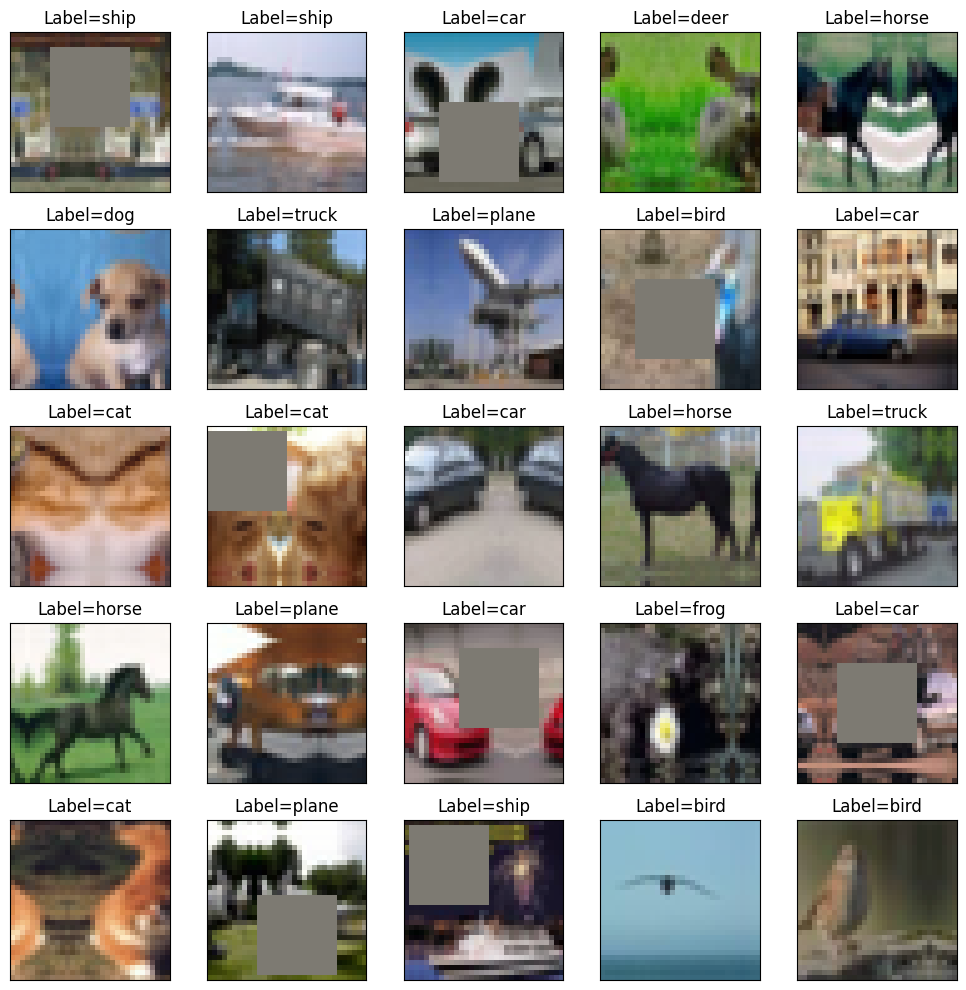

In [11]:
cifar10.sample_pictures(train_flag=True)

## Model

In [12]:
from models.resnet import *

# Loading Custom Model
net = ResNet18()

# Using cuda if available
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)

# Sending network to device
net = net.to(device)

cuda


## Model Summary

In [13]:
!pip install torchsummary
from torchsummary import summary

# Model Summary
summary(net, input_size=(3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,728
       BatchNorm2d-2           [-1, 64, 32, 32]             128
            Conv2d-3           [-1, 64, 32, 32]          36,864
       BatchNorm2d-4           [-1, 64, 32, 32]             128
            Conv2d-5           [-1, 64, 32, 32]          36,864
       BatchNorm2d-6           [-1, 64, 32, 32]             128
        BasicBlock-7           [-1, 64, 32, 32]               0
            Conv2d-8           [-1, 64, 32, 32]          36,864
       BatchNorm2d-9           [-1, 64, 32, 32]             128
           Conv2d-10           [-1, 64, 32, 32]          36,864
      BatchNorm2d-11           [-1, 64, 32, 32]             128
       BasicBlock-12           [-1, 64, 32, 32]               0
           Conv2d-13          [-1, 128, 16, 16]          73,728
      BatchNorm2d-14          [-1, 128,

## LR Finder

In [22]:
steps_per_epoch = len(trainloader)
steps_per_epoch

98

In [24]:
# total_steps = 24 * steps_per_epoch
# total_steps

2352

  0%|          | 0/200 [00:00<?, ?it/s]

Stopping early, the loss has diverged
Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 1.01E-04


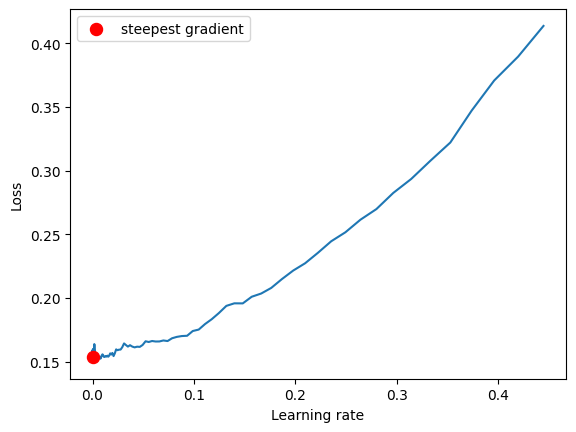

In [26]:
#https://github.com/davidtvs/pytorch-lr-finder

import copy
import torch
from torch_lr_finder import LRFinder
import torch.nn as nn
import torch.optim as optim
import numpy as np

net_exp = copy.deepcopy(net)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net_exp.parameters(), lr=1e-3, momentum=0.85)
lr_finder = LRFinder(net_exp, optimizer, criterion, device="cuda")
lr_finder.range_test(trainloader, start_lr=1e-5, end_lr=1, num_iter=200, step_mode="exp")
lr_finder.plot(log_lr=False)
lr_finder.reset()

## Define a Loss function and optimizer

In [27]:
import torch.optim as optim
import torch.nn as nn
from torch.optim.lr_scheduler import StepLR

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.01, momentum=0.9)
#scheduler = StepLR(optimizer, step_size=6, gamma=0.2)
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=0.1, steps_per_epoch=len(trainloader),total_steps=total_steps,
                                                epochs=20,pct_start=0.2,
                                                anneal_strategy='linear')

## Training & Testing

In [28]:
# Load train and test model
from main import *

train = train()
test = test()

EPOCHS= 18

for epoch in range(EPOCHS):  # loop over the dataset multiple times
  #train.execute(net, device, batch, optimizer, criterion, epoch)
  train.execute(net, device, trainloader, optimizer, scheduler, criterion, epoch)
  test.execute(net, device, testloader, criterion)

print('Finished Training')

Epoch: 0,Loss=0.20 Batch_id=97 Accuracy=93.80: 100%|██████████| 98/98 [00:36<00:00,  2.66it/s]


Test set: Average loss: 0.0007, Accuracy: 9013/10000 (90.13%)



Epoch: 1,Loss=0.24 Batch_id=97 Accuracy=92.47: 100%|██████████| 98/98 [00:37<00:00,  2.62it/s]


Test set: Average loss: 0.0007, Accuracy: 8923/10000 (89.23%)



Epoch: 2,Loss=0.25 Batch_id=97 Accuracy=91.29: 100%|██████████| 98/98 [00:37<00:00,  2.58it/s]


Test set: Average loss: 0.0007, Accuracy: 8929/10000 (89.29%)



Epoch: 3,Loss=0.28 Batch_id=97 Accuracy=90.91: 100%|██████████| 98/98 [00:38<00:00,  2.57it/s]


Test set: Average loss: 0.0010, Accuracy: 8652/10000 (86.52%)



Epoch: 4,Loss=0.27 Batch_id=97 Accuracy=90.77: 100%|██████████| 98/98 [00:38<00:00,  2.55it/s]


Test set: Average loss: 0.0010, Accuracy: 8623/10000 (86.23%)



Epoch: 5,Loss=0.30 Batch_id=97 Accuracy=91.19: 100%|██████████| 98/98 [00:38<00:00,  2.54it/s]


Test set: Average loss: 0.0009, Accuracy: 8681/10000 (86.81%)



Epoch: 6,Loss=0.27 Batch_id=97 Accuracy=91.29: 100%|██████████| 98/98 [00:39<00:00,  2.51it/s]


Test set: Average loss: 0.0008, Accuracy: 8717/10000 (87.17%)



Epoch: 7,Loss=0.26 Batch_id=97 Accuracy=91.73: 100%|██████████| 98/98 [00:39<00:00,  2.51it/s]


Test set: Average loss: 0.0008, Accuracy: 8830/10000 (88.30%)



Epoch: 8,Loss=0.21 Batch_id=97 Accuracy=92.09: 100%|██████████| 98/98 [00:39<00:00,  2.50it/s]


Test set: Average loss: 0.0011, Accuracy: 8658/10000 (86.58%)



Epoch: 9,Loss=0.21 Batch_id=97 Accuracy=92.22: 100%|██████████| 98/98 [00:39<00:00,  2.49it/s]


Test set: Average loss: 0.0007, Accuracy: 8962/10000 (89.62%)



Epoch: 10,Loss=0.25 Batch_id=97 Accuracy=92.64: 100%|██████████| 98/98 [00:39<00:00,  2.50it/s]


Test set: Average loss: 0.0009, Accuracy: 8782/10000 (87.82%)



Epoch: 11,Loss=0.19 Batch_id=97 Accuracy=92.81: 100%|██████████| 98/98 [00:39<00:00,  2.49it/s]


Test set: Average loss: 0.0008, Accuracy: 8873/10000 (88.73%)



Epoch: 12,Loss=0.23 Batch_id=97 Accuracy=93.02: 100%|██████████| 98/98 [00:39<00:00,  2.49it/s]


Test set: Average loss: 0.0006, Accuracy: 9181/10000 (91.81%)



Epoch: 13,Loss=0.19 Batch_id=97 Accuracy=93.45: 100%|██████████| 98/98 [00:39<00:00,  2.49it/s]


Test set: Average loss: 0.0006, Accuracy: 9120/10000 (91.20%)



Epoch: 14,Loss=0.31 Batch_id=97 Accuracy=93.61: 100%|██████████| 98/98 [00:39<00:00,  2.48it/s]


Test set: Average loss: 0.0007, Accuracy: 9056/10000 (90.56%)



Epoch: 15,Loss=0.19 Batch_id=97 Accuracy=93.96: 100%|██████████| 98/98 [00:39<00:00,  2.48it/s]


Test set: Average loss: 0.0007, Accuracy: 9046/10000 (90.46%)



Epoch: 16,Loss=0.15 Batch_id=97 Accuracy=94.18: 100%|██████████| 98/98 [00:39<00:00,  2.49it/s]


Test set: Average loss: 0.0007, Accuracy: 9086/10000 (90.86%)



Epoch: 17,Loss=0.26 Batch_id=97 Accuracy=94.43: 100%|██████████| 98/98 [00:39<00:00,  2.46it/s]


Test set: Average loss: 0.0006, Accuracy: 9214/10000 (92.14%)

Finished Training


## Display an image from the test set

Files already downloaded and verified


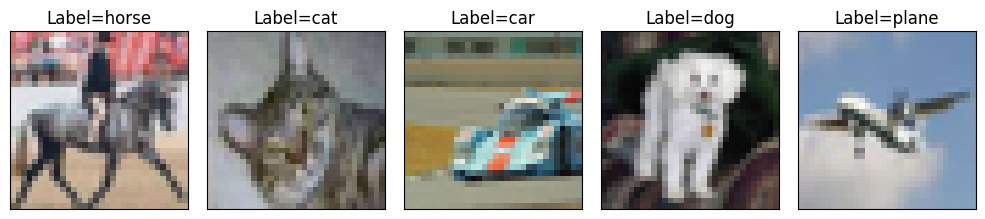

In [29]:
images, labels = cifar10.sample_pictures(train_flag=False, return_flag = True)

## Prediction of sampe test set

In [30]:
images,labels = images.to(device),labels.to(device)
outputs = net(images)
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                              for j in range(5)))

Predicted:  horse   cat   car   dog plane


In [31]:
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image
from torchvision.models import resnet50

idx = 4
model = net
target_layers = [model.layer4[-1]]
input_tensor = images[idx].unsqueeze(dim=0)# Create an input tensor image for your model..
# Note: input_tensor can be a batch tensor with several images!

# Construct the CAM object once, and then re-use it on many images:
cam = GradCAM(model=model, target_layers=target_layers)

# You can also use it within a with statement, to make sure it is freed,
# In case you need to re-create it inside an outer loop:
# with GradCAM(model=model, target_layers=target_layers, use_cuda=args.use_cuda) as cam:
#   ...

# We have to specify the target we want to generate
# the Class Activation Maps for.
# If targets is None, the highest scoring category
# will be used for every image in the batch.
# Here we use ClassifierOutputTarget, but you can define your own custom targets
# That are, for example, combinations of categories, or specific outputs in a non standard model.

targets = [ClassifierOutputTarget(labels[idx])]

# You can also pass aug_smooth=True and eigen_smooth=True, to apply smoothing.
grayscale_cam = cam(input_tensor=input_tensor, targets=targets)

# In this example grayscale_cam has only one image in the batch:
grayscale_cam = grayscale_cam[0, :]
visualization = show_cam_on_image(unnormalize(images[idx].cpu()), grayscale_cam, use_rgb=True, image_weight=0.7)

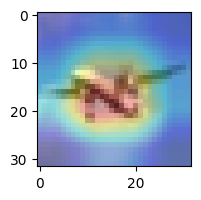

In [32]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(2, 2))
ax.imshow(visualization)

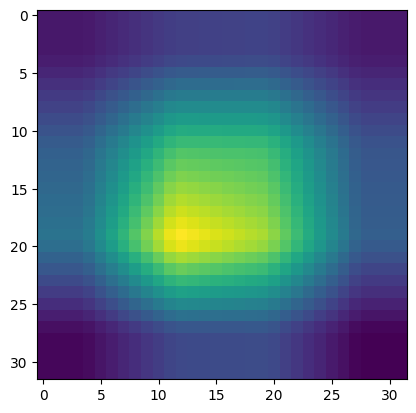

In [33]:
import matplotlib.pyplot as plt
plt.imshow(grayscale_cam)

In [34]:
labels

tensor([7, 3, 1, 5, 0], device='cuda:0')

In [35]:
list(classes)

['plane',
 'car',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

In [36]:
images[0].shape

torch.Size([3, 32, 32])

## Evaluating Training Accuracy

In [45]:
# from evaluate import *
# calAccuracy(net, trainloader, device)

## Evaluating Test Accuracy

In [46]:
# calAccuracy(net, testloader, device)

## Evaluating test Accuracy over different classes

In [47]:
# calClassAccuracy(net, testloader,classes, device)

## Misclassified Images

In [44]:
# from utils import plot_misclassified_images
# plot_misclassified_images(net, testloader, classes, device)

In [42]:
def plot_grad_cam_images(model, test_loader, classes, device):
    # set model to evaluation mode
    model.eval()
    target_layers = [model.layer4[-1]]

    # Construct the CAM object once, and then re-use it on many images:
    cam = GradCAM(model=model, target_layers=target_layers)

    misclassified_images = []
    actual_labels = []
    actual_targets = []
    predicted_labels = []

    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            _, pred = torch.max(output, 1)
            for i in range(len(pred)):
                if pred[i] != target[i]:
                    actual_targets.append(target[i])
                    misclassified_images.append(data[i])
                    actual_labels.append(classes[target[i]])
                    predicted_labels.append(classes[pred[i]])

    # Plot the misclassified images
    fig = plt.figure(figsize=(12, 5))
    for i in range(10):
        sub = fig.add_subplot(2, 5, i+1)
        input_tensor = misclassified_images[i].unsqueeze(dim=0)
        targets = [ClassifierOutputTarget(actual_targets[i])]
        grayscale_cam = cam(input_tensor=input_tensor, targets=targets)
        grayscale_cam = grayscale_cam[0, :]
        visualization = show_cam_on_image(unnormalize(misclassified_images[i].cpu()), grayscale_cam, use_rgb=True, image_weight=0.7)

        # npimg = unnormalize(misclassified_images[i].cpu())
        # plt.imshow(npimg, cmap='gray', interpolation='none')

        # npimg = unnormalize(misclassified_images[i].cpu())
        plt.imshow(visualization)
        sub.set_title("Actual: {}, Pred: {}".format(actual_labels[i], predicted_labels[i]),color='red')
    plt.tight_layout()
    plt.show()

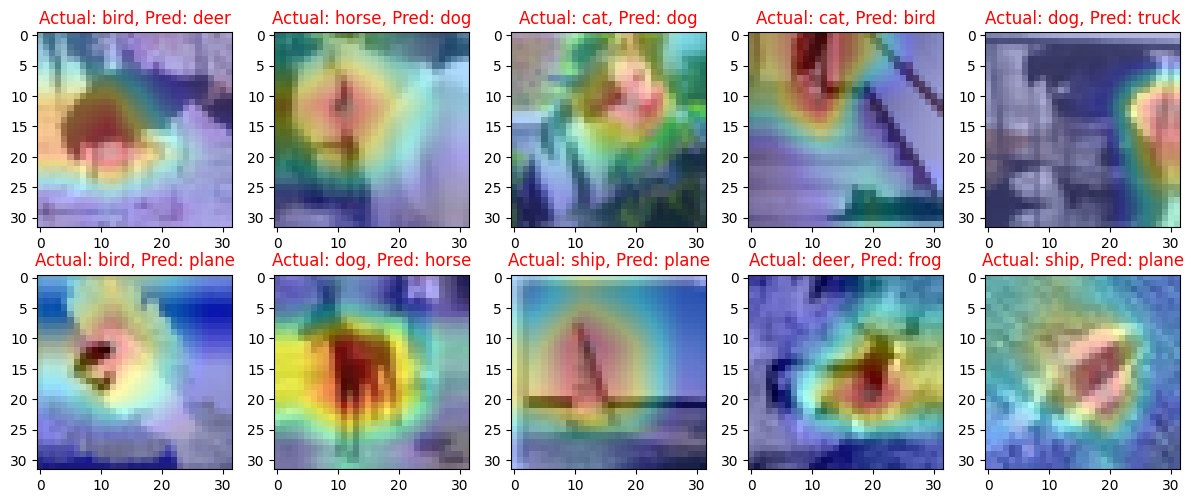

In [43]:
plot_grad_cam_images(net, testloader, classes, device)